# Case study: SGD hyperparameters

In [2]:
import sys
import matplotlib 
import matplotlib.pyplot as plt
from pathlib import Path
import itertools

import numpy as np 
import pandas as pd
import seaborn as sns
import torch

sys.path.append('..')
from src.data import datasets
from src.data import transforms as data_transforms
from src.utils import common_utils
from src.utils import datamodels_utils as dm_utils
from src.utils import data_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_style('whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [8]:
cmap = plt.get_cmap('tab10')
hist_kws = dict(element='step', lw=2, alpha=0.75, stat='count')
font_kws = dict(title_fs=17, label_fs=15, legend_fs=15, ticks_fs=14)

dsets = {
    'train': datasets.CIFAR(True, True, transform=data_transforms.CIFAR_TRANSFORMS['test']),
    'test': datasets.CIFAR(True, False, transform=data_transforms.CIFAR_TRANSFORMS['test'])
}

dm_names = {
    'large LR': r'High SGD noise ($\mathcal{A}_1$)',
    'small LR': r'Low SGD noise ($\mathcal{A}_2$)'
}

dm_paths = {
    'large LR': '../datamodels/cifar10_large-lr.pt',
    'small LR': '../datamodels/cifar10_small-lr.pt'
}

Files already downloaded and verified
Files already downloaded and verified


## Model accuracies
Accuracies of CIFAR-10 models trained with high and low SGD noise. These models are used to compute the datamodel matrices $\theta^{(1)}$ and $\theta^{(2)}$ corresponding to models trained with high and low SGD noise respectively.

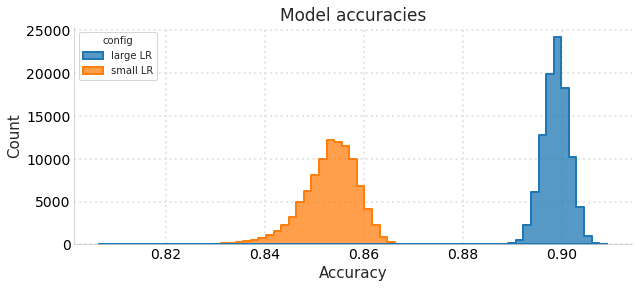

In [9]:
df = pd.read_pickle('metadata/cifar_accs.pkl')

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax = sns.histplot(data=df, x='test accuracy', hue='config', **hist_kws)
common_utils.update_ax(ax, 'Model accuracies', 'Accuracy', 'Count', legend_loc=False, **font_kws)
sns.move_legend(ax, 'upper left')

## Datamodel sparsity
Compare distribution over (row-wise) fraction of non-zeros in datamodels matrices $\theta^{(1)}$ and $\theta^{(2)}$.

[None, None, None, None]

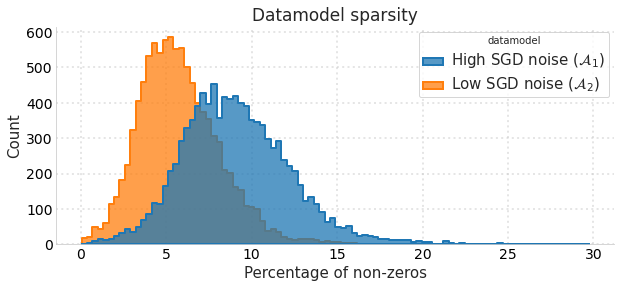

In [10]:
dfs = []
sp_map = {}

for key, pth in dm_paths.items():
    if not pth: continue
    dm = np.array(torch.load(pth)['weight']).T    
    df_ = pd.DataFrame()
    sp_map[key] = df_['sparsity'] = (np.abs(dm)>1e-6).mean(axis=1)*100 
    df_['datamodel'] = dm_names[key]
    dfs.append(df_)

df = pd.concat(dfs).reset_index()

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax = sns.histplot(data=df, x='sparsity', hue='datamodel', **hist_kws)
common_utils.update_ax(ax, 'Datamodel sparsity', 'Percentage of non-zeros', 'Count', legend_loc=False, **font_kws)
plt.setp(ax.get_legend().get_texts(), fontsize=font_kws['legend_fs'])

## Cosine similarity between datamodels
Look at distribution over cosine similarity between datamodel vectors $\theta^{(1)}_x$ and $\theta^{(2)}_x$.

<AxesSubplot:title={'center':'Cosine similarity between datamodels $\\theta^{(1)}_x$ and $\\theta^{(2)}_x$'}, xlabel='Cosine Similarity', ylabel='Count'>

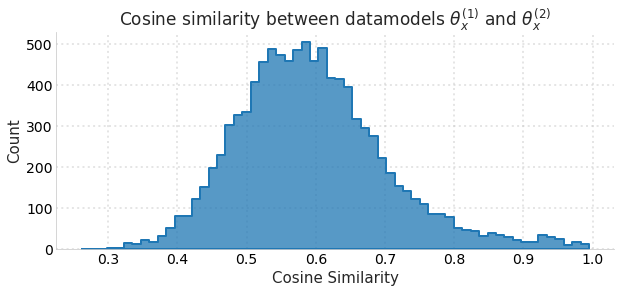

In [11]:
keys = list(itertools.combinations(dm_paths.keys(), 2))
cs_map = {} 

for k1, k2 in keys:
    if k1==k2: continue
    dm1 = torch.load(dm_paths[k1])['weight'].T.numpy()
    dm2 = torch.load(dm_paths[k2])['weight'].T.numpy()
    cs_map[(k1,k2)] = dm_utils.get_cosine_similarity(dm1, dm2)
    
fig, ax = plt.subplots(1,1,figsize=(10,4))
for idx, ((k1,k2), cs) in enumerate(cs_map.items()): 
    mean_cs = np.mean(cs)
    ax = sns.histplot(cs, color=cmap(idx), ax=ax, **hist_kws)
    
common_utils.update_ax(ax, 
                       r'Cosine similarity between datamodels $\theta^{(1)}_x$ and $\theta^{(2)}_x$', 
                       'Cosine Similarity', 'Count', legend_loc=False, **font_kws)

## Top-most datamodel influencers
Find top-most training examples that have the largest magnitude datmaodel weight in $\theta^{(1)}_x$ and $\theta^{(2)}_x$ for randomly sampled CIFAR-10 test image $x$.

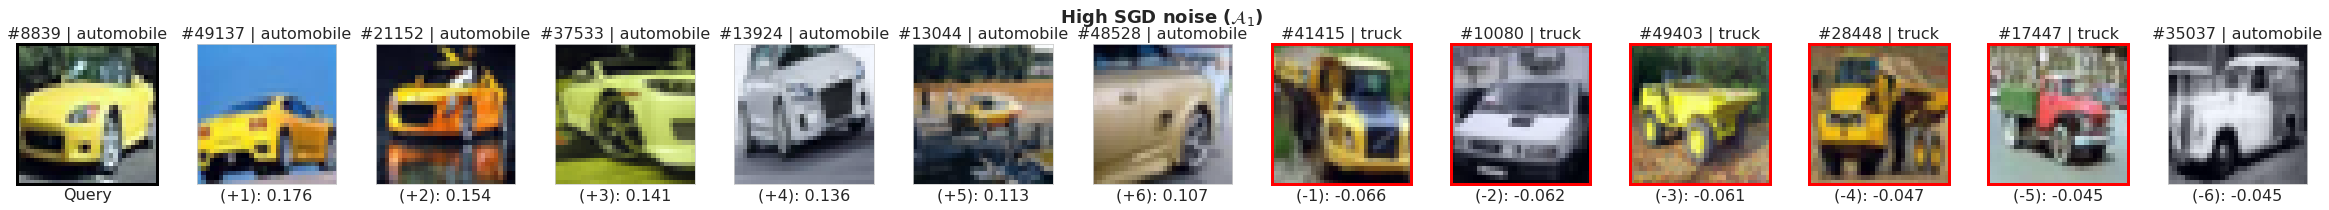

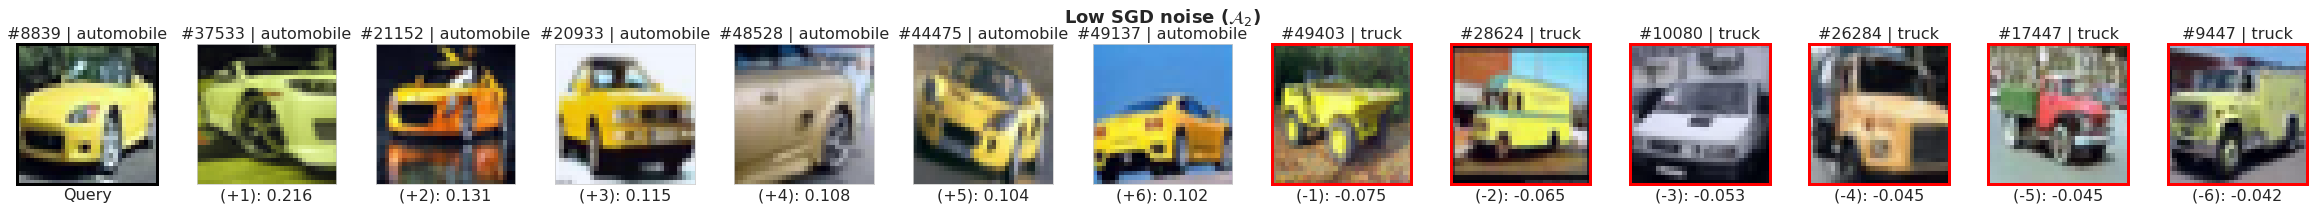

In [18]:
# visualize images with large magnitude datamodel weights  
labels = torch.load('metadata/cifar10_labels.pkl')
labels = {k: [[x] for x in v] for k, v in labels.items()}

inf_map = {}

for k, dm_path in dm_paths.items():
    dm = torch.load(dm_path)['weight'] 
    inf_map[k] = dm_utils.InfluenceVisualizer(dm, 'test', dsets, 
                                              label_indices=[0], 
                                              label_tuples=labels)
    
random_indices = np.random.randint(0, high=len(dsets['test']), size=1)
for k, inf in inf_map.items():
    fig, ax_grid = inf.plot_influencers(random_indices, 12, mode='both', 
                                        class_names=data_utils.CIFAR10_CLASS_NAMES)
    fig.suptitle(dm_names[k], y=1.1, fontsize=18, fontweight='bold')

## PCA on residual datamodel
Visualize PC components of residual datamodel matrix $\theta^{(2\setminus 1)}_x$. These PC components correspond to training directions that are more "important" for models trained with low SGD noise (algorithm $\mathcal{A}_2$) than for models trained with high SGD noise (algorithm $\mathcal{A}_1$)

Text(0.5, 0.95, 'Principal components of residual datamodel $\\theta^{(2-1)}$')

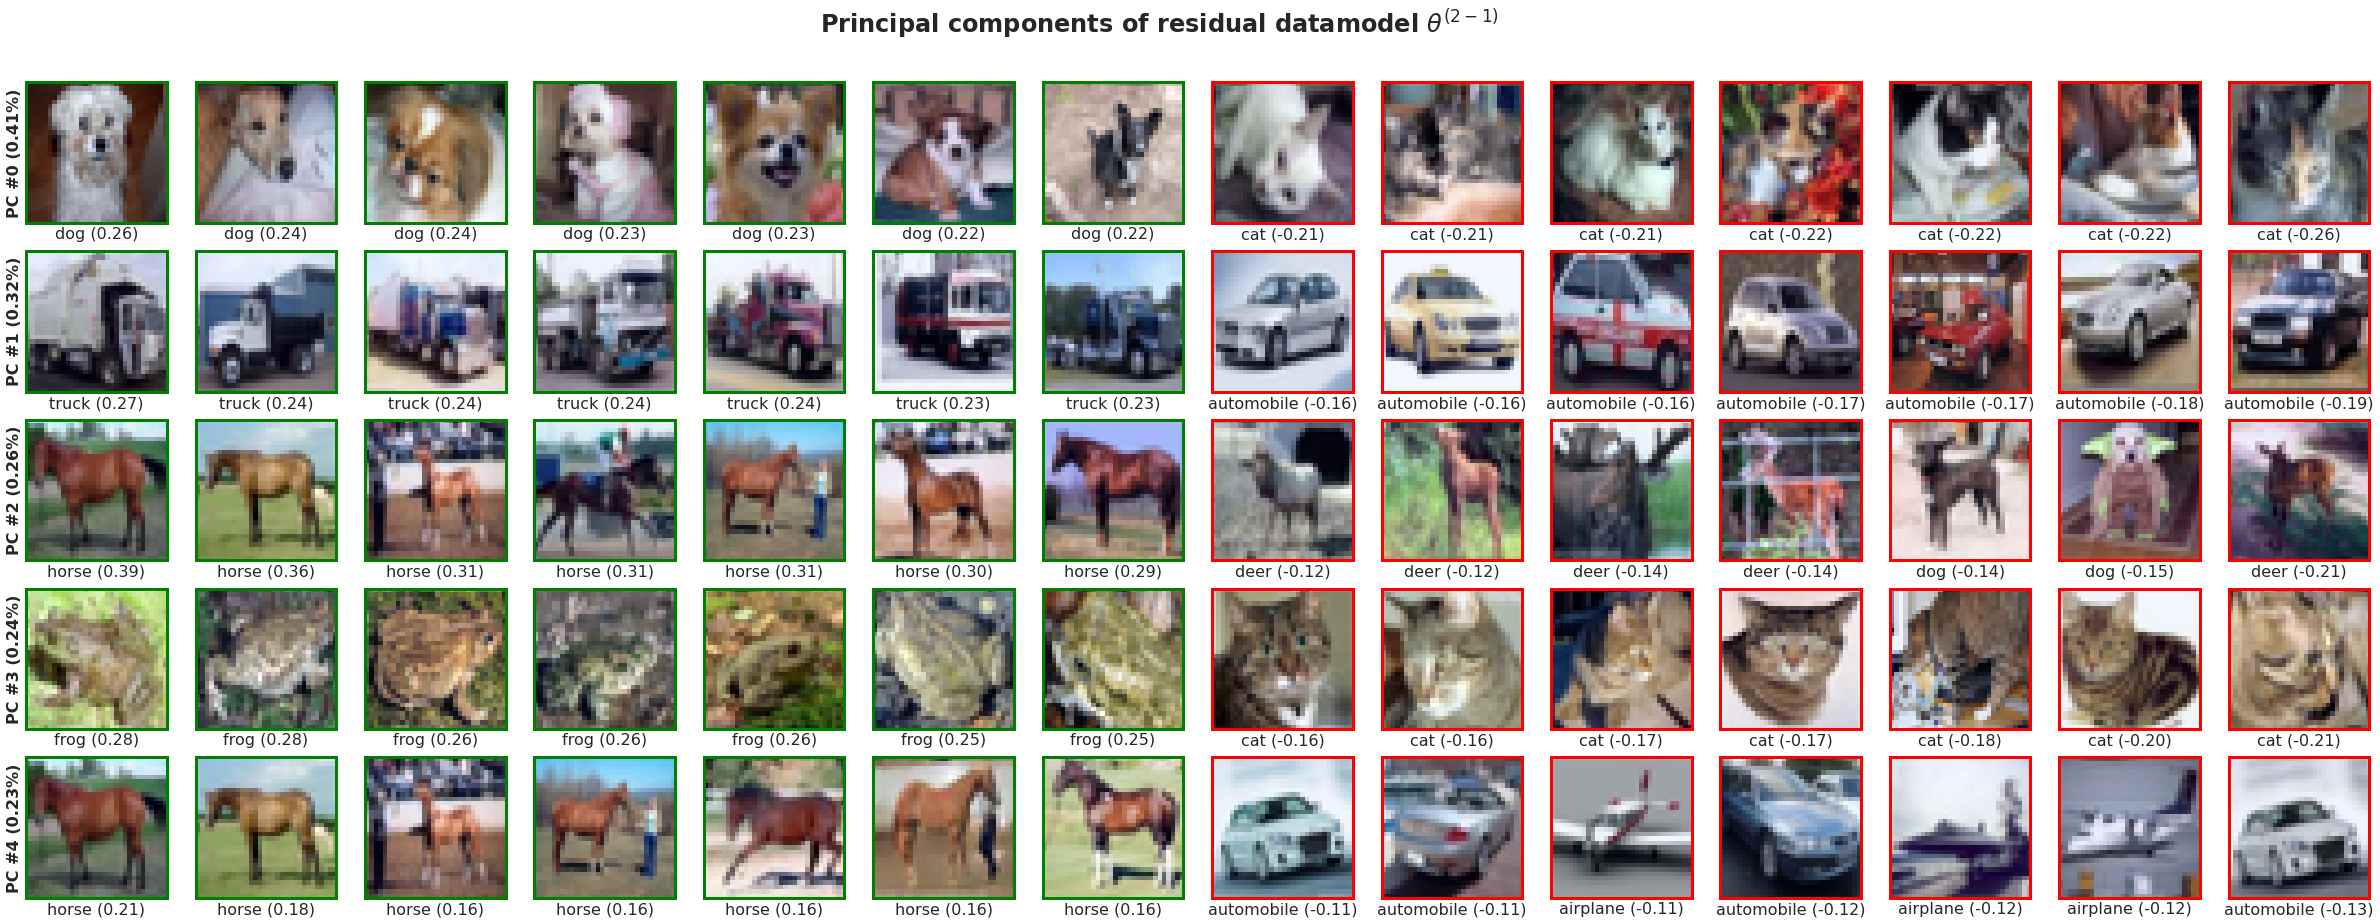

In [19]:
# compute + visualize PCA directions of residual datamodel (with-augmentation minus without-augmentation)
num_pcs = 50
pca = dm_utils.DatamodelResidualPCA(dm_paths['small LR'], dm_paths['large LR'], num_pcs, dsets)
fig, ax_grid = pca.plot_principal_component_images(range(5), 7, 
                                                   class_names=dict(zip(range(10),data_utils.CIFAR10_CLASS_NAMES)))
fig.suptitle(r'Principal components of residual datamodel $\theta^{(2-1)}$', fontsize=24, fontweight='bold', y=0.95)

## Explained variance of residual model PCs
PC components of residual datamodel matrix $\theta^{(2\setminus 1)}_x$ have high explained variance with respect to datamodel matrix $\theta^{(2)}$ (low SGD noise) and low explained variance with respect to datamodel matrix $\theta^{(1)}$ (high SGD noise).

<AxesSubplot:title={'center':'Comparison of explained variance fraction'}, xlabel='Explained variance under Algorithm $\\mathcal{A}_1$ (large LR)', ylabel='Explained variance under Algorithm $\\mathcal{A}_2$ (small LR)'>

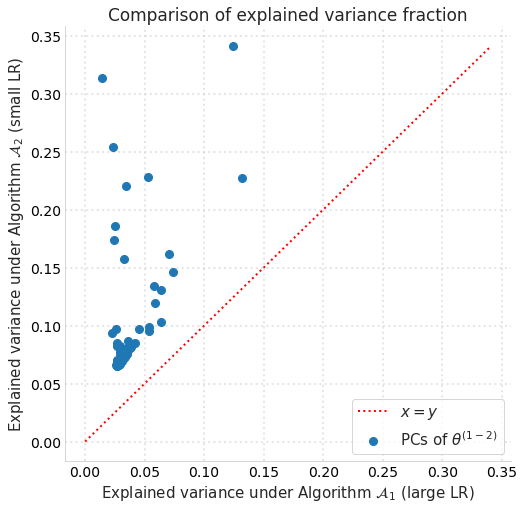

In [20]:
# visualize explained variance 
device = torch.device('cpu')
comps = torch.FloatTensor(pca.pca_components)
dm_map = {k: torch.FloatTensor(dm_utils.load_datamodel(v)) for k, v in dm_paths.items()}
ev_map = {k: dm_utils.get_explained_variance(dm, comps, device, batch_size=100)*100 for k, dm in dm_map.items()}

fig, ax = plt.subplots(1,1,figsize=(8,8))
xy = np.linspace(0, max(max(ev_map['large LR']), max(ev_map['small LR'])))
ax.plot(xy, xy, color='red', ls=':', lw=2, label=r'$x=y$')
ax.scatter(ev_map['large LR'], ev_map['small LR'], marker='o', s=64, label=r'PCs of $\theta^{(1-2)}$')
common_utils.update_ax(ax, 'Comparison of explained variance fraction', 
                       r'Explained variance under Algorithm $\mathcal{A}_1$ (large LR)',
                       r'Explained variance under Algorithm $\mathcal{A}_2$ (small LR)',
                       **font_kws)

## Subpopulations surfaced by PC directions #0 and #1
Visualize subpopulations of test examples surfaced by PC directions #0 and #1---the directions that we analyze in the paper. These test examples correspond to examples whose residual datamodel vectors $\theta^{(2-1)}_x$ are most (positively) aligned with the PC directions.

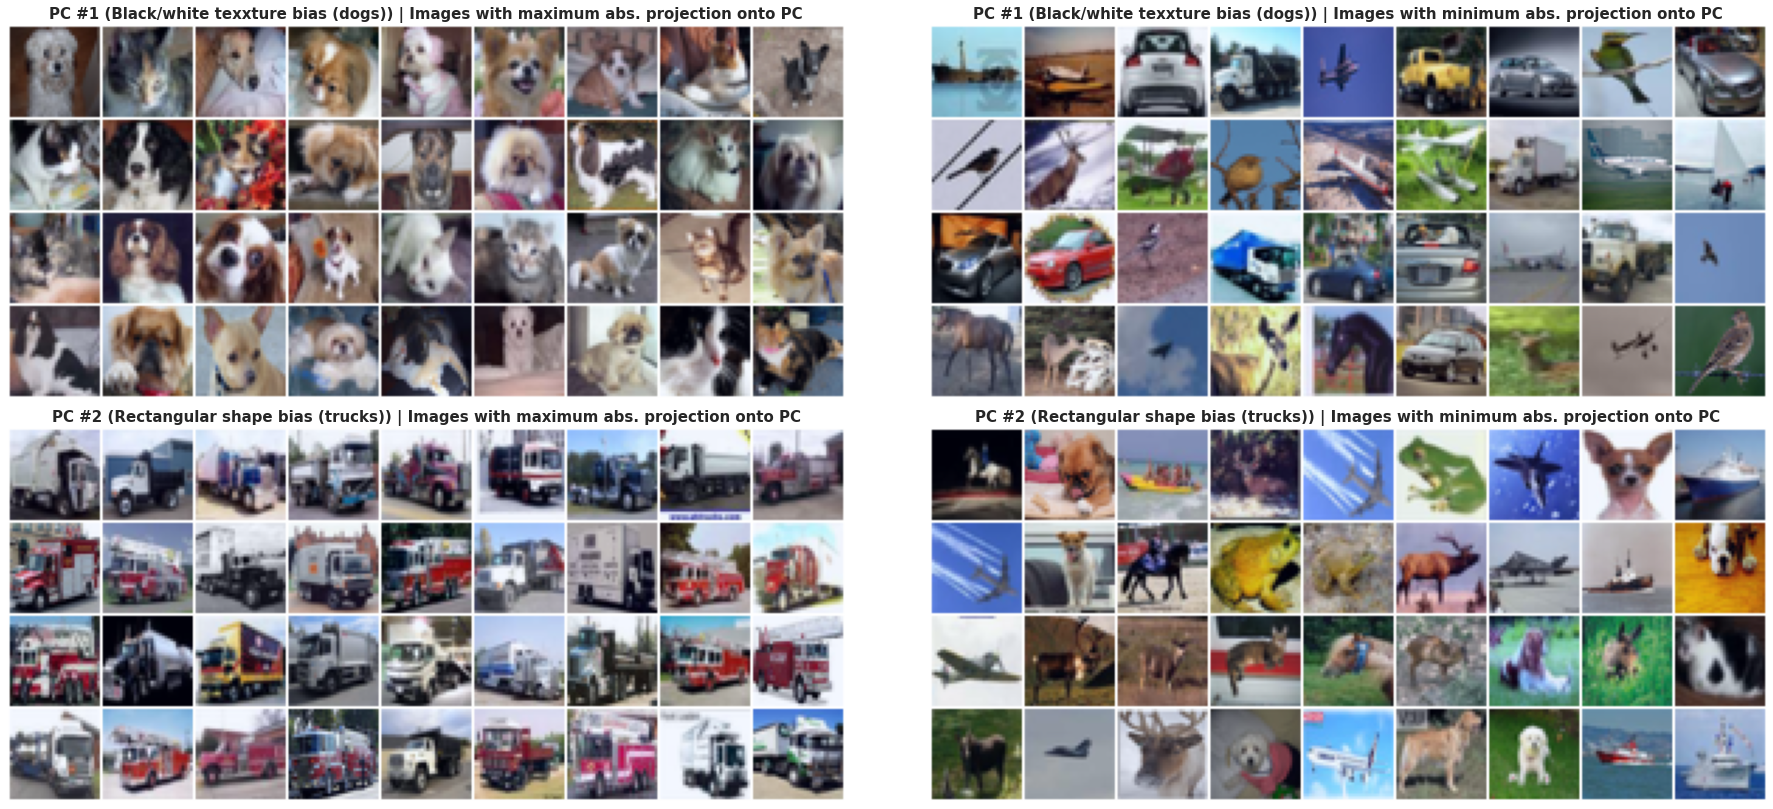

In [23]:
# visualize pca subpopulations of PC #2 (spider web) and PC#5 (polka dots)
comp_indices=[0,1]
num_comps = len(comp_indices)
num_imgs = 36
per_row = 9
title_fs = 15

fig, axs = plt.subplots(num_comps, 2, figsize=(25, 5.67*num_comps))
feat_names = ['Black/white texxture bias (dogs)', 'Rectangular shape bias (trucks)']

for idx, ax_pair in enumerate(axs):
    direction = dm_utils.Direction(pca.pca_components[comp_indices[idx]], pca.X, pca.datasets_map['test'], use_abs=True)
    titles = ['PC #{} ({}) | Images with maximum abs. projection onto PC'.format(comp_indices[idx]+1, feat_names[idx]), 
              'PC #{} ({}) | Images with minimum abs. projection onto PC'.format(comp_indices[idx]+1, feat_names[idx])]
    direction.visualize_grid(num_imgs, per_row, titles=titles, axs=ax_pair, padding=1)

    for ax, title in zip(ax_pair, titles):
        ax.set_title(title, fontsize=title_fs, fontweight='bold')

fig.tight_layout()
fig.subplots_adjust(wspace=0.075)
None

## Effect of distinguishing feature transformations
Plot treatment effect of distinguishing feature transformations corresponding to "black/white texture bias" and "rectangular shape bias". See scripts in `counterfactuals/` for code. 

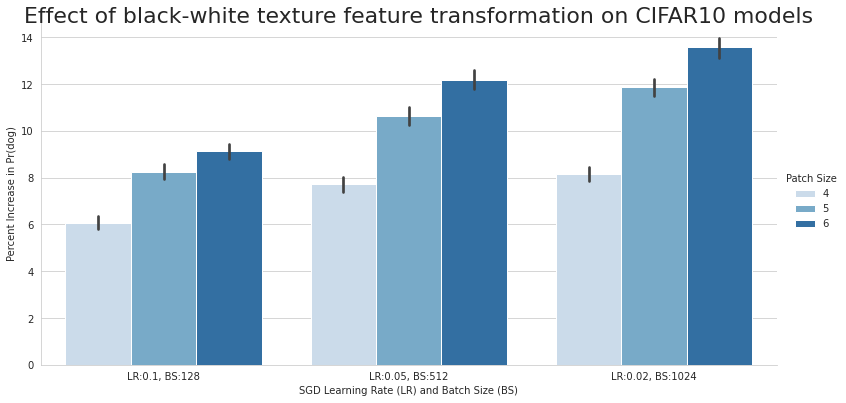

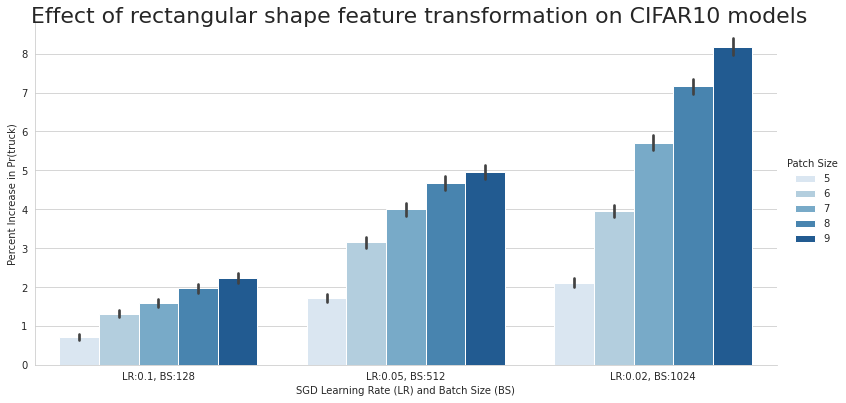

In [22]:
def plot_truck():
    df = pd.read_pickle('metadata/cifar_truck_dataframe.pkl')
    effect_col = '$\Pr(truck|do(patch))-\Pr(truck|control)$'
    new_effect_col = 'Percent Increase in Pr(truck)'

    df['datamodel'] = df['datamodel'].apply(lambda d: {
        'LR:0.1 BS:128': 'LR:0.1, BS:128',
        'LR:0.02 BS:1024': 'LR:0.02, BS:1024',
        'LR:0.05 BS:512': 'LR:0.05, BS:512'
    }.get(d, d))

    df = df.sort_values('datamodel', ascending=False)

    df = df.rename(columns={'truck window patch': 'Patch Size', 
                            effect_col: new_effect_col,
                            'datamodel': 'SGD Learning Rate (LR) and Batch Size (BS)'})

    df[new_effect_col] *= 100
    df['Patch Size'] = df['Patch Size'].astype(int)
    df = df[df['Patch Size'].apply(lambda p: p not in {3,4})]

    fg = sns.catplot(y=new_effect_col, x='SGD Learning Rate (LR) and Batch Size (BS)',  palette='Blues',
                     hue='Patch Size', kind='bar', data=df, aspect=2, height=5.5)

    fg.fig.suptitle(f'Effect of rectangular shape feature transformation on CIFAR10 models', fontsize=22, y=1.01)
    return fg.fig

def plot_dog():
    df = pd.read_pickle('metadata/cifar_dog_dataframe.pkl')
    effect_col = '$\Pr(dog|do(patch))-\Pr(dog|control)$'
    new_effect_col = 'Percent Increase in Pr(dog)'

    df['datamodel'] = df['datamodel'].apply(lambda d: {
        'LR:0.1 BS:128': 'LR:0.1, BS:128',
        'LR:0.02 BS:1024': 'LR:0.02, BS:1024',
        'LR:0.05 BS:512': 'LR:0.05, BS:512'
    }.get(d, d))

    df = df.sort_values('datamodel', ascending=False)

    df = df.rename(columns={'black/white patch': 'Patch Size', 
                            effect_col: new_effect_col,
                            'datamodel': 'SGD Learning Rate (LR) and Batch Size (BS)'})

    df[new_effect_col] *= 100
    df['Patch Size'] = df['Patch Size'].astype(int)
    df = df[df['Patch Size'].apply(lambda p: p not in {0,3})]

    fg = sns.catplot(y=new_effect_col, x='SGD Learning Rate (LR) and Batch Size (BS)',  palette='Blues',
                     hue='Patch Size', kind='bar', data=df, aspect=2, height=5.5)

    fg.fig.suptitle(f'Effect of black-white texture feature transformation on CIFAR10 models', fontsize=22, y=1.01)
    return fg.fig

fig = plot_dog()
fig = plot_truck()
None